<a href="https://colab.research.google.com/github/Bazinga97/ML_Projects/blob/main/Quora_Question_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install distance
!pip install fuzzywuzzy
!pip install scikit-learn
!pip install "dask[complete]"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=c73794074d10642a7f5ae135008871edb9b4ae5f56a240d0f846a63bb5eb4daa
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.6 MB/s eta 0:00:00


In [3]:
!pip install scikit-plot


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objs as go
import plotly.offline as py

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scikitplot.metrics import plot_confusion_matrix
from xgboost import XGBClassifier

sns.set()

In [6]:
df = pd.read_csv("train.csv")
df = df.sample(10000)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
187948,187948,286321,286322,Why do case studies have high ecological valid...,What are some high impact journals which accep...,0
59787,59787,104666,104667,What are some Indian inventions and discoveries?,What is the greatest invention by Indians whic...,0


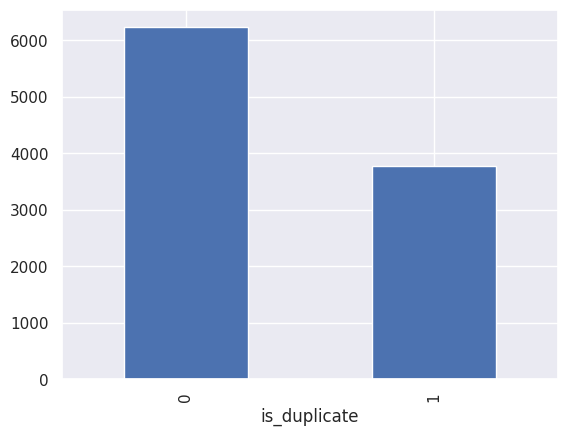

In [7]:
df.groupby('is_duplicate')['id'].count().plot.bar();

In [8]:
qids = pd.Series(df['qid1'].to_list() + df['qid2'].to_list())
num_unique_questions = len(np.unique(qids))
non_unique_questions = np.sum(qids.value_counts() > 1)
percentage_non_unique_questions = ( non_unique_questions / num_unique_questions ) * 100

print("Statistics on Question IDs:")
print(f"Number of Unique Questions: {num_unique_questions}")
print(f"Number of Non-Unique Questions: {non_unique_questions}")
print(f"Percentage of Non-Unique Questions: {percentage_non_unique_questions:.2f}%")
print(f"Maximum Times a Question Got Repeated: {qids.value_counts().iloc[0]}")

Statistics on Question IDs:
Number of Unique Questions: 19296
Number of Non-Unique Questions: 606
Percentage of Non-Unique Questions: 3.14%
Maximum Times a Question Got Repeated: 7


In [9]:
pair_duplicates = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()
num_duplicated_questions = pair_duplicates.shape[0] - df.shape[0]
print(f"Number of duplicated questions: {num_duplicated_questions}")

Number of duplicated questions: 0


In [10]:
df = df.fillna('')

In [11]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda x: len(x.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda x: len(x.split(" ")))

def normalized_word_count(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1 & w2))
df['word_common'] = df.apply(normalized_word_count, axis = 1)


def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])


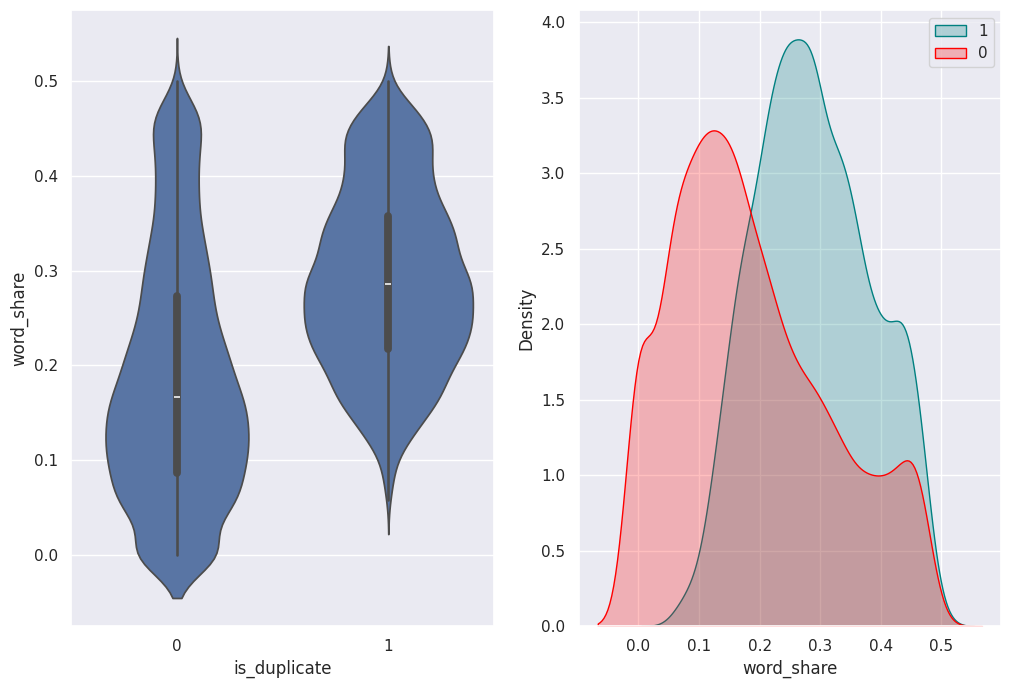

In [12]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = "is_duplicate", y = "word_share", data = df)

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['is_duplicate'] == 1]['word_share'], label = '1', color='teal', fill = True)
sns.kdeplot(df[df['is_duplicate'] == 0]['word_share'], label = '0', color='red', fill = True)
plt.legend()
plt.show()

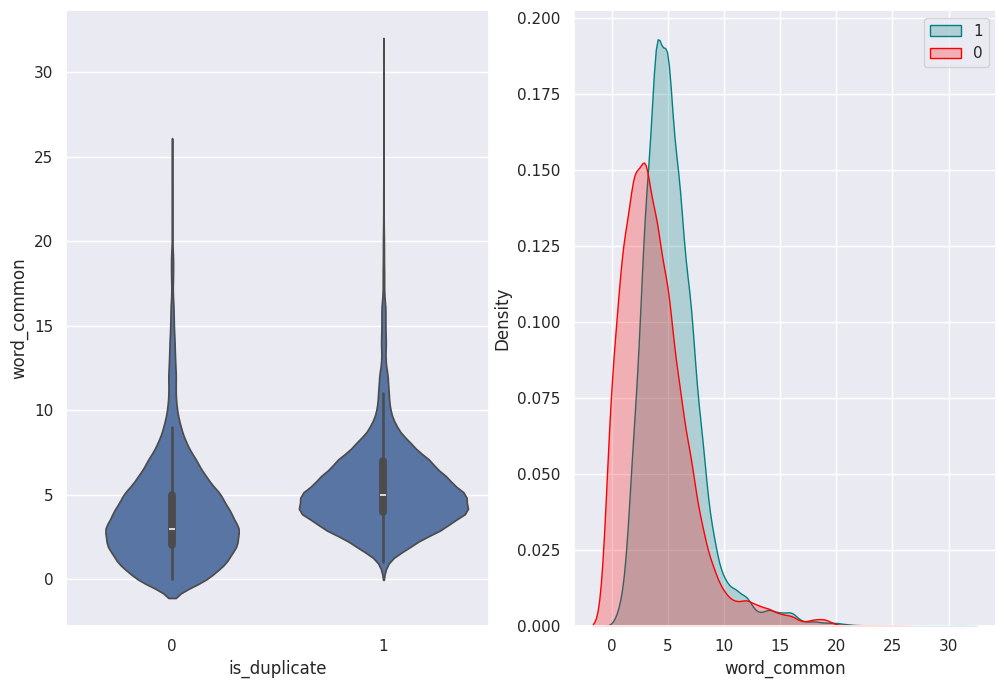

In [13]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = "is_duplicate", y = "word_common", data = df)

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['is_duplicate'] == 1]['word_common'], label = '1', color='teal', fill = True)
sns.kdeplot(df[df['is_duplicate'] == 0]['word_common'], label = '0', color='red', fill = True)
plt.legend()
plt.show()

In [18]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)


    porter = PorterStemmer()
    pattern = re.compile('\W')

    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)


    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()


    return x

In [20]:
SAFE_DIV = 0.0001

def get_token_features(q1, q2):

    token_features = [0.0]*10
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    q1_words = set([token for token in q1_tokens if token not in STOP_WORDS])
    q2_words = set([token for token in q2_tokens if token not in STOP_WORDS])

    q1_stops = set([token for token in q1_tokens if token in STOP_WORDS])
    q2_stops = set([token for token in q2_tokens if token in STOP_WORDS])

    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_tokens).intersection(set(q2_stops)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2

    return token_features

In [21]:
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [22]:
def extract_features(df):
    df['question1'] = df['question1'].fillna("").apply(preprocess)
    df['question2'] = df['question2'].fillna("").apply(preprocess)
    token_features = df.apply(lambda x: get_token_features(x['question1'], x['question2']), axis = 1)
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [23]:
df = extract_features(df)

In [24]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs) : 7540
Number of data points in class 0 (non duplicate pairs) : 12460


In [25]:
stopwords = set(STOPWORDS)
duplicate_string = " ".join(p)
non_duplicate_string = " ".join(n)

Word Cloud for Duplicate Question pairs


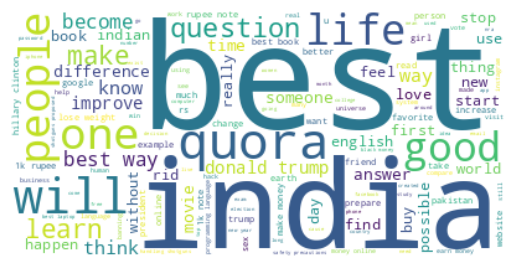

In [26]:
wc = WordCloud(background_color="white", max_words=len(p), stopwords=stopwords)
wc.generate(duplicate_string)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Non Duplicate Question pairs


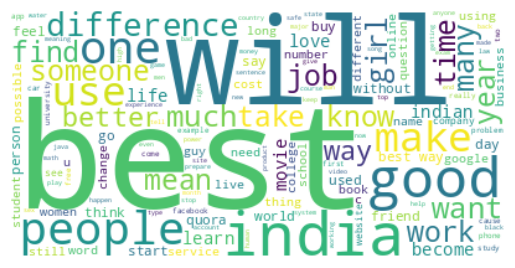

In [27]:
wc = WordCloud(background_color="white", max_words=len(n), stopwords=stopwords)
wc.generate(non_duplicate_string)
print ("Word Cloud for Non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

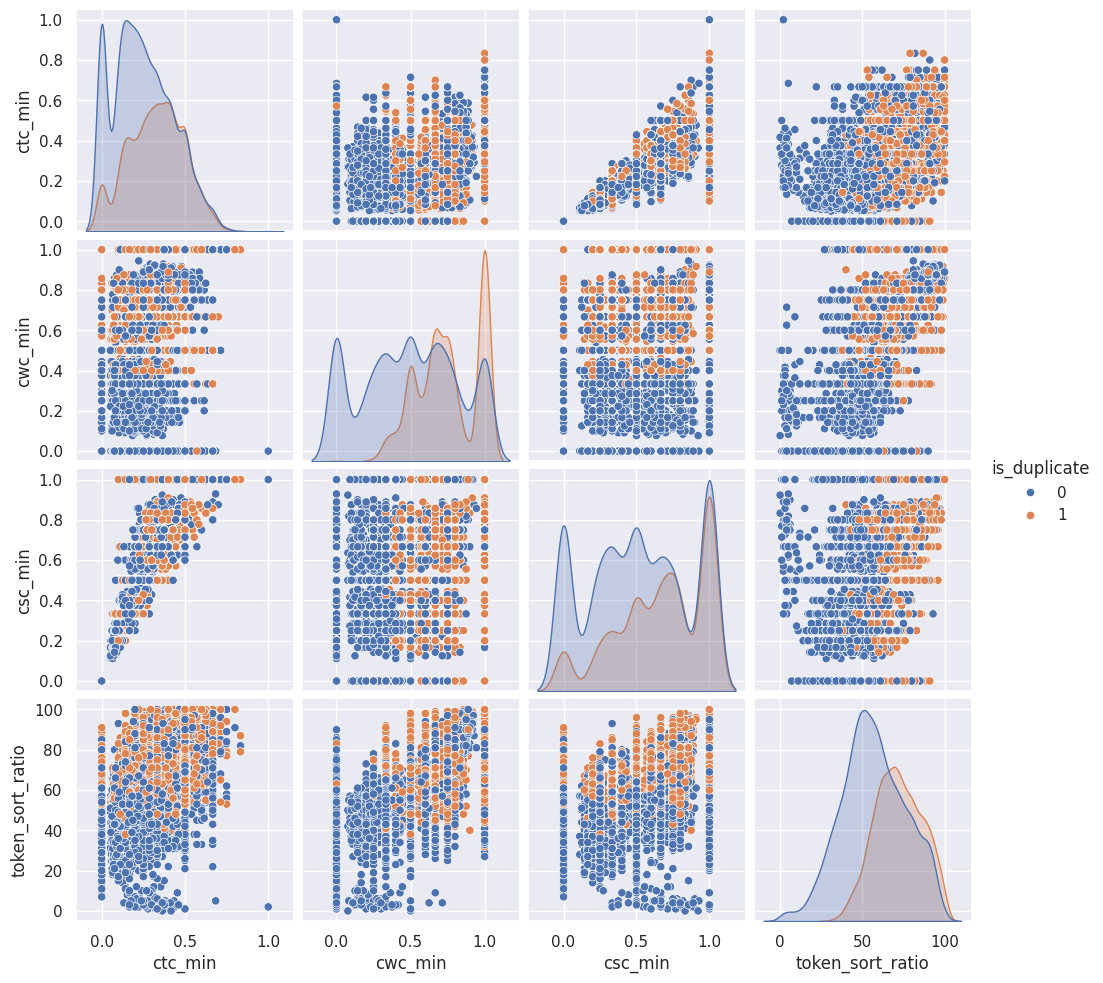

In [28]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

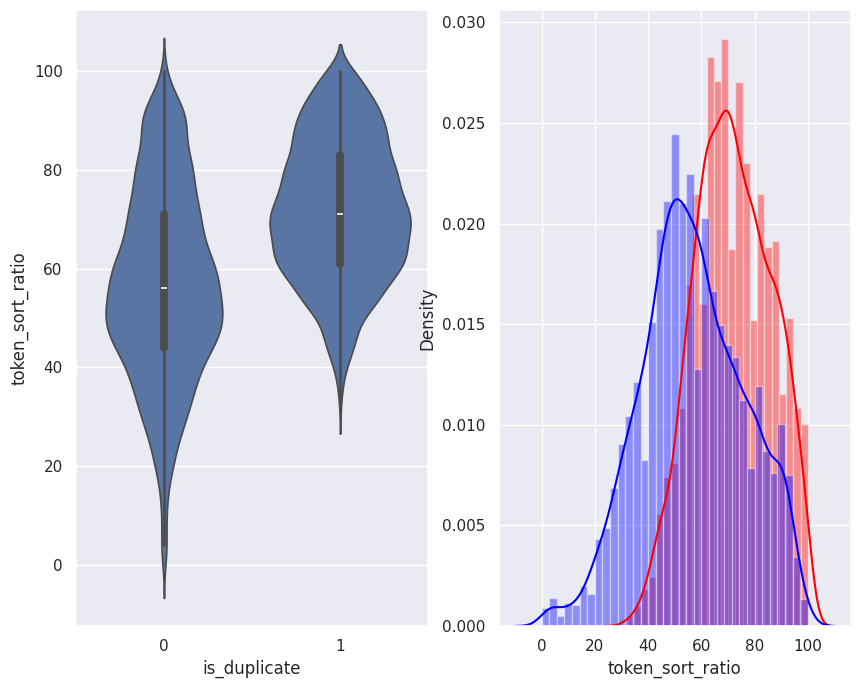

In [29]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [30]:
df_sampled = df[:5000]
scaler = MinMaxScaler()
X = scaler.fit_transform(df_sampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq',
                                     'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,
                                     'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = df_sampled['is_duplicate'].values

In [31]:
tsne2d = TSNE(
    n_components = 2,
    init = 'random',
    random_state = 101,
    method = 'barnes_hut',
    n_iter = 1000,
    verbose = 2,
    angle = 0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.040s...
[t-SNE] Computed neighbors for 5000 samples in 1.450s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.147248
[t-SNE] Computed conditional probabilities in 0.302s
[t-SNE] Iteration 50: error = 86.4650040, gradient norm = 0.0847384 (50 iterations in 3.193s)
[t-SNE] Iteration 100: error = 71.5748138, gradient norm = 0.0135180 (50 iterations in 1.684s)
[t-SNE] Iteration 150: error = 69.5550690, gradient norm = 0.0070776 (50 iterations in 2.660s)
[t-SNE] Iteration 200: error = 68.7607498, gradient norm = 0.0050738 (50 iterations in 2.318s)
[t-SNE] Iteration 250: error = 68.2763748, gradient norm = 0.0041761

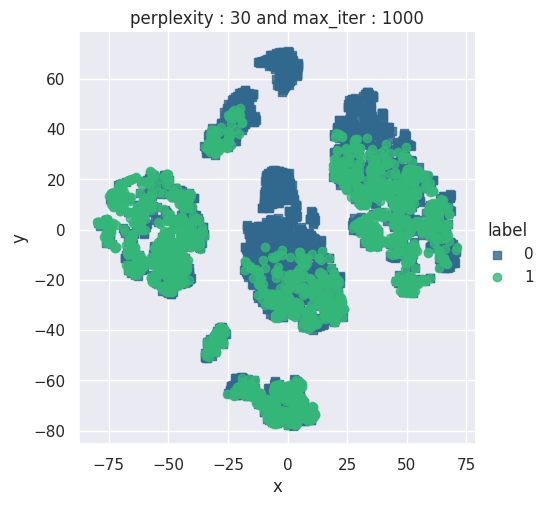

In [32]:
df_tsne_2d = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})


sns.lmplot(data = df_tsne_2d, x='x', y='y', hue='label', fit_reg=False,palette="viridis",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [33]:
tsne3d = TSNE(
    n_components=3,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.477s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.147248
[t-SNE] Computed conditional probabilities in 0.160s
[t-SNE] Iteration 50: error = 88.9837723, gradient norm = 0.0440626 (50 iterations in 7.422s)
[t-SNE] Iteration 100: error = 70.3028412, gradient norm = 0.0070127 (50 iterations in 3.434s)
[t-SNE] Iteration 150: error = 68.7774582, gradient norm = 0.0039710 (50 iterations in 3.080s)
[t-SNE] Iteration 200: error = 68.1084824, gradient norm = 0.0024820 (50 iterations in 3.502s)
[t-SNE] Iteration 250: error = 67.7802734, gradient norm = 0.0018586

In [34]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')


In [35]:
questions = list(df['question1']) + list(df['question2'])
tfidf = TfidfVectorizer()
tfidf.fit_transform(questions)

<20000x14933 sparse matrix of type '<class 'numpy.float64'>'
	with 202669 stored elements in Compressed Sparse Row format>

In [40]:
!pip install spacy



In [41]:
!python -m spacy download en_core_web_lg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 606.8 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [36]:
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

In [42]:
nlp = spacy.load('en_core_web_lg')
vecs1 = []
for qu1 in list(df['question1']):
    doc1 = nlp(qu1)
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        vec1 = word1.vector
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

In [43]:
vecs2 = []
for qu2 in list(df['question2']):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        vec2 = word2.vector
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

In [44]:
df_q1 = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)
df_q2 = pd.DataFrame(df.q2_feats_m.values.tolist(), index= df.index)

In [45]:
df_q1['id']=df['id']
df_q2['id']=df['id']

In [46]:
df_questions_to_vector = df_q1.merge(df_q2, on='id', how='left')
result = df.merge(df_questions_to_vector, on='id', how='left')

In [47]:
final_df = result.drop(columns = ['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'q1_feats_m', 'q2_feats_m'], axis = 1)
y_true = result['is_duplicate']
y_true = list(map(int, y_true.values))
final_df.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,1,1,50,121,8,18,2.0,26.0,0.076923,2,...,193.031194,-193.578159,150.053192,-89.378560,-323.903103,35.704010,142.106108,-281.101733,-248.099336,138.055236
1,1,1,48,85,7,15,1.0,20.0,0.050000,2,...,180.507211,-69.756765,68.930544,81.882164,-80.189514,31.537074,12.347864,-113.847008,-214.790941,188.595625
2,1,1,70,107,13,22,4.0,33.0,0.121212,2,...,120.591736,-40.309030,-36.159579,164.974887,-104.411587,9.611829,11.829717,-123.926165,-347.536758,-9.516056
3,1,1,40,78,7,18,1.0,21.0,0.047619,2,...,123.863079,-87.131552,87.782268,-83.139924,-135.025290,125.278762,29.074690,-18.760829,-172.963540,49.649839
4,1,1,44,40,9,7,2.0,16.0,0.125000,2,...,159.205982,-48.900990,-21.033556,36.157343,-58.049176,-13.002072,15.040183,-17.081758,-275.790962,89.043249


In [48]:
cols = list(final_df.columns)
for i in cols:
    if final_df[i].dtype == 'object':
        print(i)
    final_df[i] = final_df[i].apply(pd.to_numeric)

In [49]:
X_train,X_test, y_train, y_test = train_test_split(final_df, y_true, stratify=y_true, test_size=0.3)

In [50]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7000, 626)
Number of data points in test data : (3000, 626)


For values of n_estimators =  10 The log loss is: 0.44299326945423906
For values of n_estimators =  50 The log loss is: 0.4423609117784871
For values of n_estimators =  100 The log loss is: 0.47305761788751194
For values of n_estimators =  200 The log loss is: 0.5189147323729157
For values of n_estimators =  500 The log loss is: 0.5688739937834867


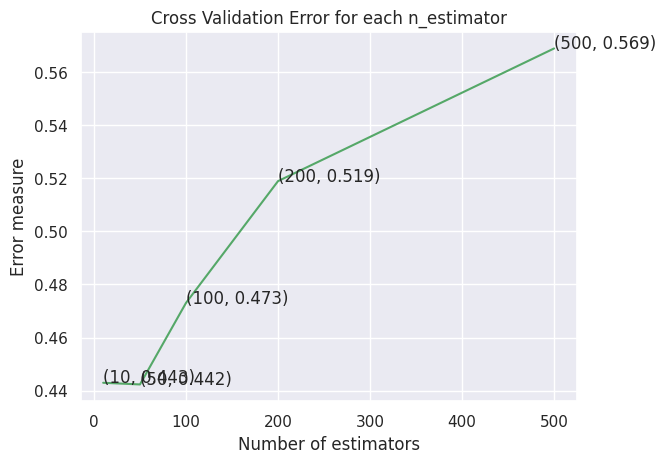

In [51]:
log_error_array = []
n_estimators = [10, 50, 100, 200, 500]

for i in n_estimators:
    clf = XGBClassifier(n_estimators=i, random_state=42)
    clf.fit(X_train, y_train)
    predict_y = clf.predict_proba(X_test)
    loss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)

    log_error_array.append(loss)
    print('For values of n_estimators = ', i, "The log loss is:", loss)


fig, ax = plt.subplots()
ax.plot(n_estimators, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((n_estimators[i],np.round(txt,3)), (n_estimators[i],log_error_array[i]))
plt.title("Cross Validation Error for each n_estimator")
plt.xlabel("Number of estimators")
plt.ylabel("Error measure")
plt.show()


In [52]:
best_n = np.argmin(log_error_array)
clf = XGBClassifier(n_estimators=n_estimators[best_n], random_state=42)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [53]:
predict_y = clf.predict_proba(X_train)
print('For values of best n_estimator = ', n_estimators[best_n], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf.predict_proba(X_test)
print('For values of best n_estimator = ', n_estimators[best_n], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

For values of best n_estimator =  50 The train log loss is: 0.08862657208258129
For values of best n_estimator =  50 The test log loss is: 0.4423609117784871
Total number of data points : 3000


<Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

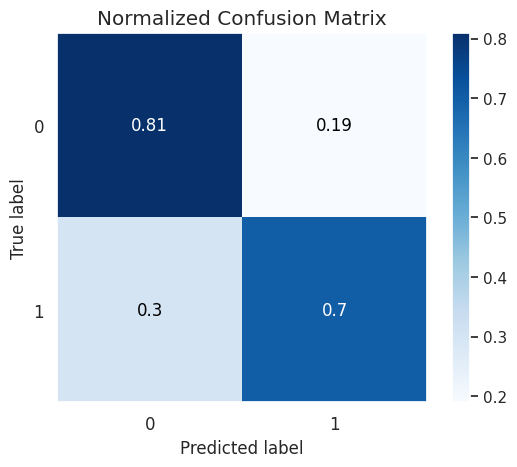

In [54]:
plot_confusion_matrix(y_test, predicted_y, normalize = True)